In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

In [32]:
class Models():
    def __init__(self, params):
        self.algorithms = [
            ("svm", SVC(**params))
        ]
    
    def train_all(self, data, response):
        for name, algorithm in self.algorithms:
            algorithm.fit(X=data, y=response)

    def save(self, sufix):
        for name, algorithm in self.algorithms:
            dump(algorithm, f"models/{name}_model_{sufix}.joblib")

    def predict(self, X_val):
        predictions = []

        for name, model in self.algorithms:
            predictions.append((name, model.predict(X_val)))
        
        return predictions
    
    def predict_proba(self, X_val):
        predictions = []

        for name, model in self.algorithms:
            predictions.append((name, model.predict_proba(X_val)[::,1]))
        
        return predictions
    
    def cross_validate_model(self, name, model, X, y, cv, scoring):
        res = cross_validate(model, X, y, cv=cv, scoring=scoring)
        return [name, res["test_accuracy"].mean(), res["test_precision"].mean(), res["test_recall"].mean(), res["test_f1"].mean(), res["test_mcc"].mean()]
    
    def cross_validate(self, X, y, cv, scoring):
        score_list = []
        for name, model in self.algorithms:
            score_list.append(self.cross_validate_model(name, model, X, y, cv, scoring))
        
        return pd.DataFrame(score_list, columns=["algorithm", "accuracy", "precision", "recall", "f1", "mcc"])

    def cv_predict(self, X, y, cv):
        self.predictions = cross_val_predict(self.model_instance, X, y, cv=cv)
        return self.get_metrics(y)

    def get_metrics(self, X_val,y_true):
        export_list = []
        predictions = self.predict(X_val)
        for name, y_pred in predictions:
            acc_value = accuracy_score(y_pred=y_pred, y_true=y_true) 
            recall_value = recall_score(y_pred=y_pred, y_true=y_true)
            precision_value = precision_score(y_pred=y_pred, y_true=y_true) 
            f1_value = f1_score(y_pred=y_pred, y_true=y_true)
            mcc_value = matthews_corrcoef(y_pred=y_pred, y_true=y_true)
            cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
            export_list.append((name, acc_value, recall_value, precision_value, f1_value, mcc_value, cm))

        return pd.DataFrame(export_list, columns=["algorithm", "acc", "recall", "precision", "f1", "mcc", "cm"])

In [3]:
df = pd.read_csv('../data/encoded/physicochemical_WOLS870103.csv')
df

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_2003,p_2004,p_2005,p_2006,p_2007,p_2008,p_2009,p_2010,p_2011,response
0,-0.41,2.36,-1.29,-0.98,0.01,0.57,-0.98,0.57,-3.14,-1.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,-0.41,-1.40,-1.03,1.11,-3.14,-1.29,0.09,-1.03,0.84,0.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.41,-1.29,0.09,-1.40,4.13,-0.98,-1.14,-1.29,-1.29,0.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.41,-1.40,0.84,0.57,-1.03,0.57,0.30,0.01,-1.14,2.23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,-0.41,0.57,1.11,1.11,0.85,0.30,0.01,0.30,-3.14,1.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,-0.41,-1.40,0.84,-3.14,4.13,-0.98,-0.98,-1.14,-1.03,0.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7708,-0.41,0.30,-1.40,2.23,2.23,0.30,-0.98,-1.14,-1.40,2.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7709,-0.41,0.30,-1.40,2.23,2.23,0.30,-0.98,-1.14,-1.40,2.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7710,-0.41,0.57,0.45,-1.29,2.23,0.30,-1.14,-0.07,0.84,0.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
seed = 42

In [6]:
X = df.drop('response', axis=1).values
y = df['response'].values

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=seed)

In [9]:
opt_params = {
    'C': 4785889.9780677445,
    'kernel': 'rbf',
    'degree': 5,
    'gamma': 'scale',
    'coef0': 7.429097448132248,
    'shrinking': False,
    'probability': True,
    'tol': 0.0043663652111854325,
    'decision_function_shape': 'ovr'
}

In [10]:
halving_params = {'C': 4.5, 'coef0': 2.2222222222222223, 'degree': 6, 'gamma': 'scale', 'kernel': 'poly', 'probability': False, 'shrinking': True, 'tol': 0.0067}

In [33]:
model_instance = Models(opt_params)
model_instance.train_all(X_train, y_train)

In [44]:
metrics_opt = model_instance.get_metrics(X_val, y_val)
metrics_opt

,algorithm,acc,recall,precision,f1,mcc,cm
0,svm,0.790346,0.752489,0.818885,0.784285,0.583034,"[[568, 117], [174, 529]]"


In [35]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary'),
    'mcc': make_scorer(matthews_corrcoef)
}

In [36]:
model_instance.cross_validate(X_train, np.squeeze(y_train), cv=5, scoring=scoring)

,algorithm,accuracy,precision,recall,f1,mcc
0,svm,0.789628,0.8099,0.750928,0.779029,0.58067


In [37]:
predictions = model_instance.predict_proba(X_test)
predictions

[('svm',
  array([0.23815048, 0.23816614, 0.23809285, 0.78343269, 0.78367073,
         0.23805007, 0.23830618, 0.70307095, 0.23828608, 0.23822664,
         0.23815048, 0.23814312, 0.23805007, 0.7839245 , 0.86513199,
         0.23840196, 0.23805007, 0.98276659, 0.23793411, 0.78379618,
         0.78334492, 0.23801317, 0.23801435, 0.23801317, 0.23866107,
         0.78344125, 0.23824185, 0.81137911, 0.78362435, 0.78379618,
         0.84390332, 0.23827463, 0.7832402 , 0.78334492, 0.78387041,
         0.23809285, 0.78362013, 0.7838686 , 0.78352235, 0.23822664,
         0.78322138, 0.23782227, 0.23816614, 0.2378472 , 0.23782227,
         0.78320667, 0.78371049, 0.78355405, 0.78380147, 0.23839948,
         0.2384258 , 0.85460693, 0.23803111, 0.23866734, 0.86592608,
         0.23821945, 0.75353984, 0.23782227, 0.23805007, 0.78361   ,
         0.78380147, 0.8447758 , 0.2380765 , 0.23809285, 1.        ,
         0.63738358, 0.23827463, 0.78342721, 0.78347177, 0.23839948,
         0.23807701, 0.78

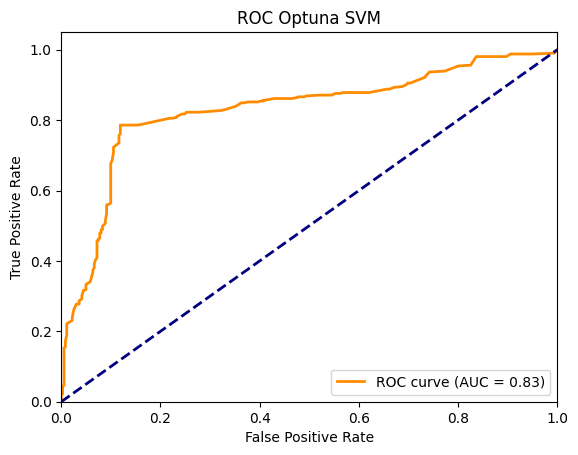

In [48]:
for name, y_pred in predictions:
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Optuna SVM')
    plt.legend(loc='lower right')
    plt.show()

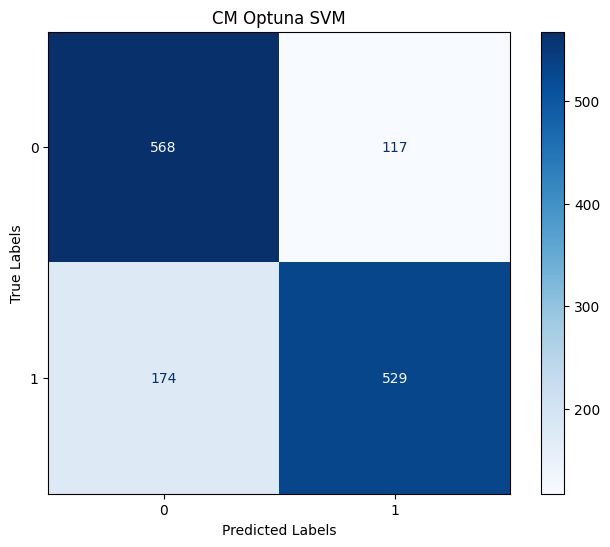

In [47]:
cm = metrics_opt["cm"].values[0]  # Extract the confusion matrix from the DataFrame

fig, ax = plt.subplots(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(ax=ax, cmap='Blues', colorbar=True)

# Customize the plot
plt.title("CM Optuna SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

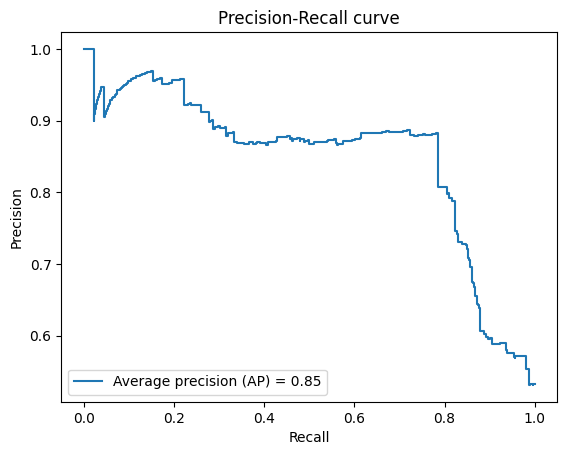

In [49]:
from sklearn.metrics import precision_recall_curve, average_precision_score

for name, y_pred in predictions:
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)

    plt.figure()
    plt.step(recall, precision, where='post', label=f'Average precision (AP) = {average_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='lower left')
    plt.show()

In [52]:
from sklearn.model_selection import learning_curve

# Define the model
model = SVC(**opt_params)

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_val, y_train_val, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=seed
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()

Exception ignored in: <function _releaseLock at 0x74f6713b42c0>
Traceback (most recent call last):
  File "/home/diegof/miniconda3/envs/transfer_learning/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


KeyboardInterrupt: 